In [1]:
import sys
from io import StringIO
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
import pandas as pd
import numpy as np
import sklearn as sk
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

path = 'AlephB_LEP_dataset_v2.csv'
data = pd.DataFrame(np.genfromtxt(path, names=True))
variables = data.columns
print(variables)

Index(['energy', 'cTheta', 'phi', 'prob_b', 'spheri', 'pt2rel', 'multip',
       'bqvjet', 'ptlrel', 'nnbjet', 'isb'],
      dtype='object')


Remember: 'isb' is our binary truth. If isb = 1 then it's a b-quark and isb = 0 if it is not. Because this is our truth, we must not include it as the input to our model. Also, 'nnbjet' is our "competitor" e.g. a model we are supposed to benchmark against. Therefore 'nnbjet' shouldn't be in our input either. Usually one would apply regularization/standardization of data at this step - but lets skip this for now and just move onto seperate the data into input, truth and benchmark:

In [2]:
input_variables = variables[(variables != 'nnbjet') & (variables != 'isb')]
input_data      = data[input_variables]
truth           = data['isb']
benchmark       = data['nnbjet']
print(input_variables)

Index(['energy', 'cTheta', 'phi', 'prob_b', 'spheri', 'pt2rel', 'multip',
       'bqvjet', 'ptlrel'],
      dtype='object')


In [3]:
benchmark.max()

0.9999

In [4]:
data.head()

,energy,cTheta,phi,prob_b,spheri,pt2rel,multip,bqvjet,ptlrel,nnbjet,isb
0,46.8299,0.3871,0.8528,0.0327,0.2105,0.0302,0.4776,0.0314,-0.0003,0.1642,0.0
1,45.6397,-0.3943,-2.2817,0.0035,0.3457,0.0314,0.3497,0.0106,-0.0003,0.1055,0.0
2,48.8960,-0.4613,-0.6139,0.0649,0.0872,0.0254,0.1288,0.1074,-0.0003,0.1183,0.0
3,39.1577,0.4668,2.4818,0.0027,0.1570,0.0147,0.2732,0.2117,0.0240,0.1612,0.0
4,43.7354,-0.7642,1.7872,0.4320,0.4873,0.0505,0.3536,0.4578,-0.0003,0.9969,1.0


Let us now divide the truth and input_data into two parts; a training sample and a validation sample:

In [5]:
input_train, input_validation, truth_train, truth_validation = train_test_split(input_data, truth, test_size=0.25)

Let us now define the scikit-learn model:

In [35]:
# model = DecisionTreeClassifier(min_samples_leaf = 20, criterion = 'entropy') 
model = DecisionTreeClassifier(max_depth = 5, criterion = 'entropy') 

Now we are ready to train! 

In [36]:
model.fit(np.array(input_train), np.array(truth_train))  ## This trains the model on input_train by comparing to the true values in truth_train.    

DecisionTreeClassifier(criterion='entropy', max_depth=5)

Now we have a trained model and we're ready to make predictions. Usually, one would have a test set (so in total one would have; a training set, a validation set AND a test set). But for simplicity, let's just predict on the validation sample. This is OK because the model has not trained on this set - if we asked the model to predict on examples on which it has trained, we would be cheating!

In [37]:
predictions = model.predict_proba(input_validation) # this asks the trained model to make predictions on input_valid. Notice we're not giving it any truth values!

predictions = pd.DataFrame(predictions)
predictions.columns = ['not_bquark', 'bquark']
normalised_predictions = (predictions['bquark'])/(predictions['bquark'] + predictions['not_bquark'])

/Users/enaj/.virtualenvs/p39/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeClassifier was fitted without feature names
  warnings.warn(


In [38]:
predictions

,not_bquark,bquark
0,0.944901,0.055099
1,0.940506,0.059494
2,0.004260,0.995740
3,0.940506,0.059494
4,0.825218,0.174782
...,...,...
8487,0.012579,0.987421
8488,0.940506,0.059494
8489,0.983209,0.016791
8490,0.940506,0.059494


In [39]:
normalised_predictions

0       0.055099
1       0.059494
2       0.995740
3       0.059494
4       0.174782
          ...   
8487    0.987421
8488    0.059494
8489    0.016791
8490    0.059494
8491    1.000000
Length: 8492, dtype: float64

In [40]:
model.feature_importances_

array([0.01185068, 0.        , 0.        , 0.77909674, 0.03387932,
       0.00726437, 0.        , 0.10727672, 0.06063217])

Let's see how many leaves our trained tree ended up having:

In [41]:
print(f"Trained tree has a depth of {model.get_depth()} and {model.get_n_leaves()} leaves.") 

Trained tree has a depth of 5 and 32 leaves.


We can now evaluate our predictions by producing a ROC-curve and calculating the AUC-score and comparing it to our 'nnbjet' competitor. 

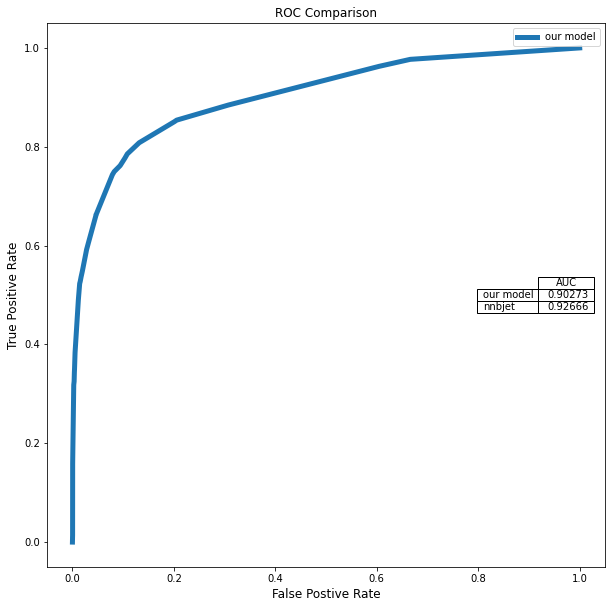

In [42]:
fpr, tpr, _ = roc_curve(truth_validation, normalised_predictions)  ## this calculates the false positive rate and the true positive rate for our model's predictions on the validation sample
fpr_nnbjet, tpr_nnbjet, _ = roc_curve(truth,benchmark) ## this calculates the false positive rate and the true postive rate for nnbjet on the entire data sample

### We can npw calculate the AUC scores of these ROC-curves
auc_score = auc(fpr,tpr)                      # this is auc score for our model
auc_score_nnbjet = auc(fpr_nnbjet, tpr_nnbjet)# this is the auc score for nnbjet


# Plot results
fig = plt.figure(figsize = [10,10])
plt.title('ROC Comparison', size = 12)
plt.plot(fpr,tpr, label = 'our model', linewidth=5)
# plt.plot(fpr_nnbjet, tpr_nnbjet, label = 'nnbjet')
plt.legend()
plt.xlabel('False Postive Rate', size = 12)
plt.ylabel('True Positive Rate', size = 12)

# Plots a table with the AUC-scores.
row_labels=['our model',
            'nnbjet']
table_vals=[[round(auc_score,5)],
            [round(auc_score_nnbjet,5)]]
col_labels=['AUC']
the_table = plt.table(cellText=table_vals,
            colWidths = [0.1]*3,
            rowLabels=row_labels,
            colLabels=col_labels,
            loc='center right')



In [96]:
iris.target_names

array(['setosa', 'versicolor', 'virginica'], dtype='<U10')

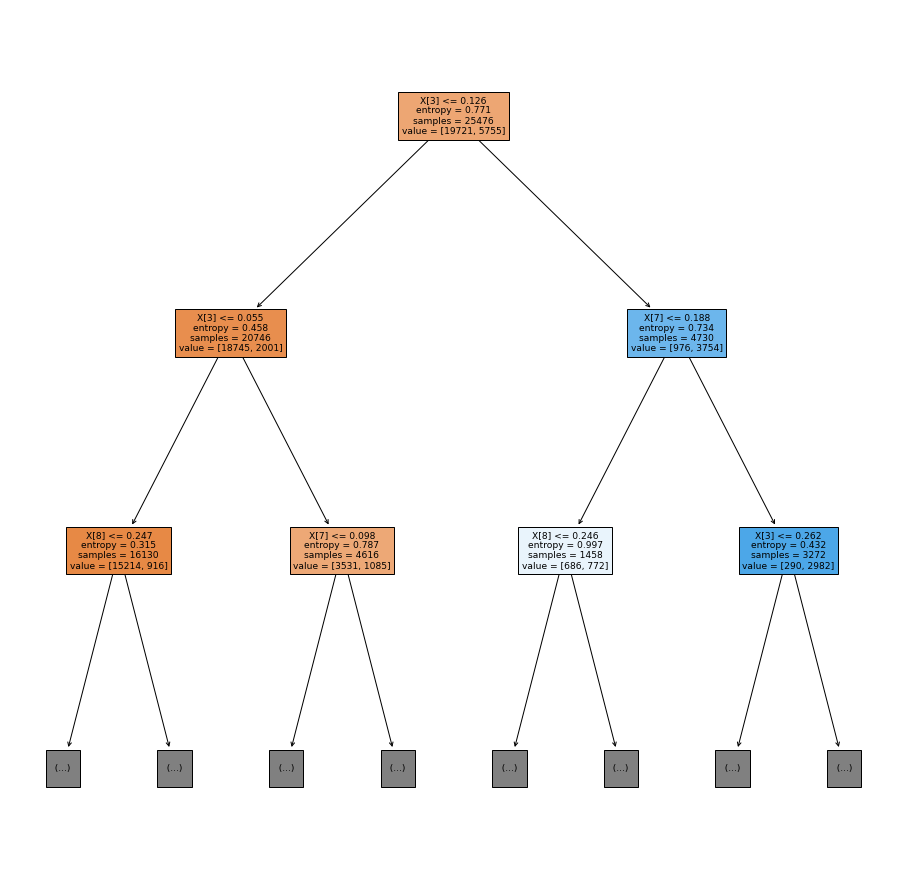

In [16]:
from sklearn import tree
plt.figure(figsize=(16,16))
tree.plot_tree(model, max_depth=2, filled=True)
plt.show()

## Regression task

In [43]:
path = 'AlephB_LEP_dataset_v2.csv'
data = pd.DataFrame(np.genfromtxt(path, names=True))
variables = data.columns
print(variables)

Index(['energy', 'cTheta', 'phi', 'prob_b', 'spheri', 'pt2rel', 'multip',
       'bqvjet', 'ptlrel', 'nnbjet', 'isb'],
      dtype='object')


In [44]:
input_variables = variables[variables != 'energy']
input_data      = data[input_variables]
truth           = data['energy']
print(input_variables)

Index(['cTheta', 'phi', 'prob_b', 'spheri', 'pt2rel', 'multip', 'bqvjet',
       'ptlrel', 'nnbjet', 'isb'],
      dtype='object')


In [45]:
input_train, input_validation, truth_train, truth_validation = train_test_split(input_data, truth, test_size=0.25)

In [46]:
model = DecisionTreeRegressor(max_depth=40, criterion='squared_error') 

In [47]:
model.fit(np.array(input_train), np.array(truth_train))  ## This trains the model on input_train by comparing to the true values in truth_train.    

DecisionTreeRegressor(max_depth=40)

In [48]:
print(f"Trained tree has a depth of {model.get_depth()} and {model.get_n_leaves()} leaves.") 

Trained tree has a depth of 40 and 25179 leaves.


In [57]:
input_test = input_validation
output_test = truth_validation
predictions = model.predict(input_test)

/Users/enaj/.virtualenvs/p39/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


In [58]:
np.mean(abs(np.array(output_test) - predictions))

3.2672301626180382

In [59]:
np.std(np.array(output_test) - predictions)

6.530269298104129

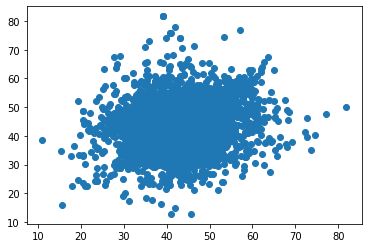

In [60]:
plt.plot(np.array(output_test), predictions, 'o')

In [74]:
model.score(input_validation, truth_validation)

/Users/enaj/.virtualenvs/p39/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


-0.19540184961386786

In [62]:
from sklearn.metrics import r2_score
r2_score(output_test,  model.predict(input_test))

/Users/enaj/.virtualenvs/p39/lib/python3.9/site-packages/sklearn/base.py:443: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(


-0.19540184961386786

In [185]:
model

DecisionTreeRegressor(max_depth=40)

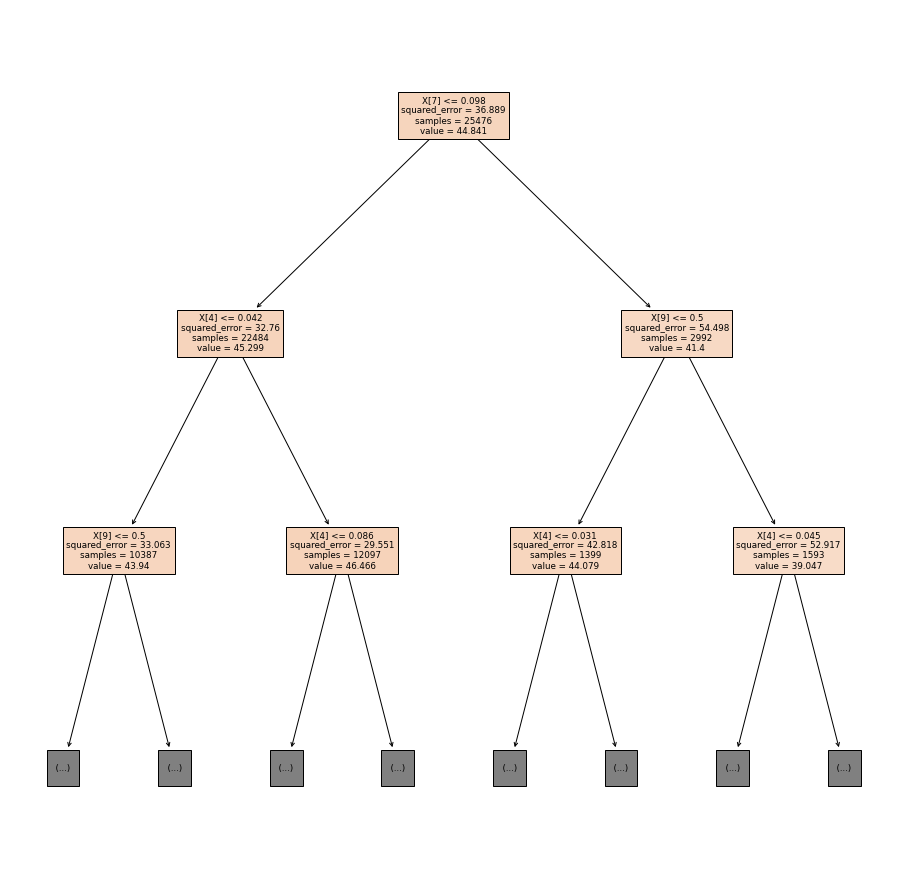

In [191]:
from sklearn import tree
plt.figure(figsize=(16,16))
tree.plot_tree(model, max_depth=2, filled=True)
plt.show()